9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Average MSE: 20590.91196010209
Average MAE: 100.46920544332858
Average RMSE: 141.58154216002714
Average R2: 0.010624615656725189


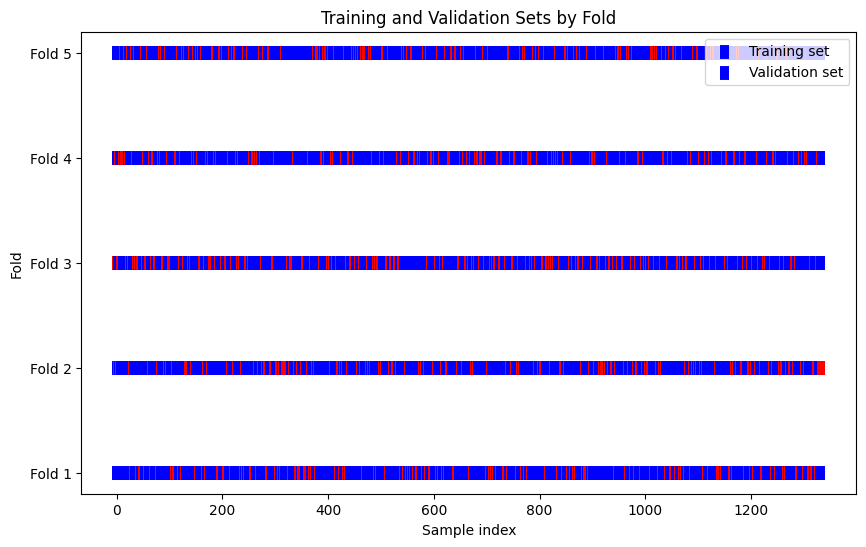

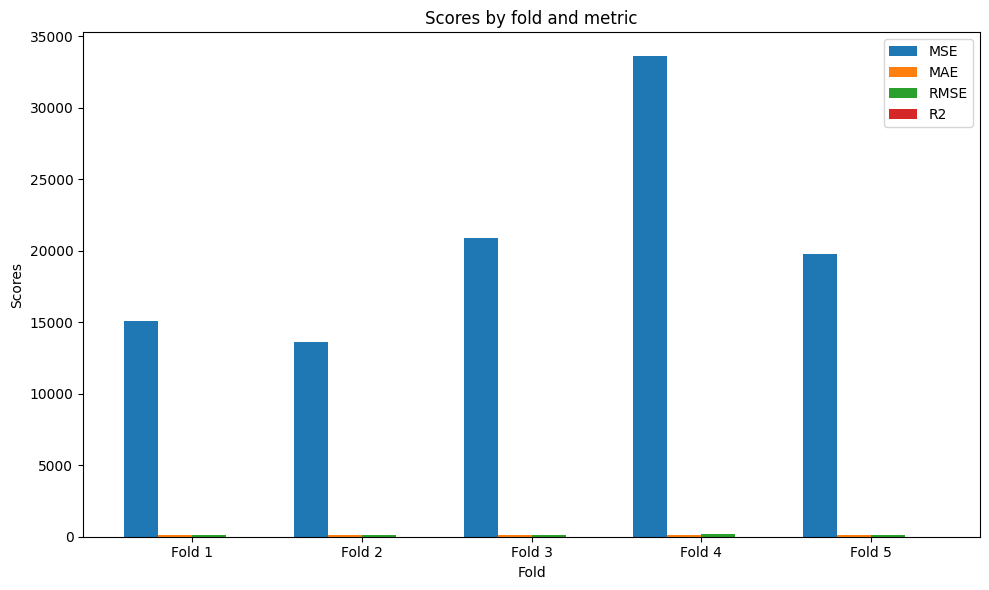

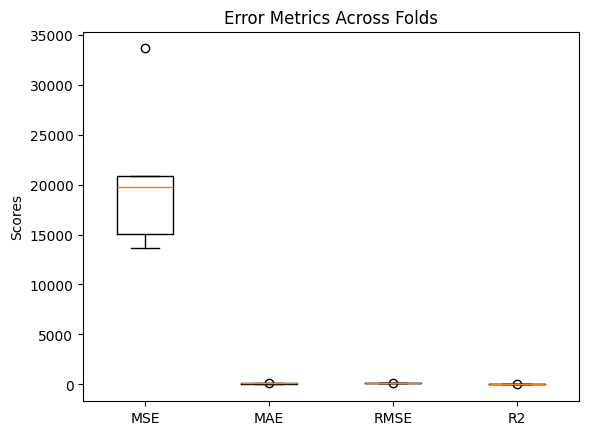

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
file_path = 'dataset.csv'
data = pd.read_csv(file_path)

# Define appliance columns and target variable
appliance_columns = ['Rooms', 'Fans', 'Lights', 'Freezes', 'Microwave Oven', 'Geyser', 'AC', 'Washing Machine', 'TV', 'PC', 'Induction Stove']
target_variable = 'pre_23_dec_unit'

# Identify unit columns for processing
unit_columns = [col for col in data.columns if '_unit' in col]

# Clean all unit columns by removing unwanted characters and converting to numeric
selected_features = appliance_columns + unit_columns
for col in selected_features:
    # Remove problematic characters (e.g., backticks)
    data[col] = data[col].astype(str).str.replace('`', '', regex=False)
    # Convert to numeric, coercing errors to NaN
    data[col] = pd.to_numeric(data[col], errors='coerce')
    # Fill NaN values with the column's median using a new method
    median_value = data[col].median()
    data[col] = data[col].fillna(median_value)

# Normalize the dataset
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = feature_scaler.fit_transform(data[selected_features])
target_scaled = target_scaler.fit_transform(data[[target_variable]])
data_scaled = np.hstack((data_scaled, target_scaled))

# Define sequence length
seq_length = 30

# Create sequences for LSTM model
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :-1])
        y.append(data[i + seq_length, -1])
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, seq_length)

# Define the LSTM model
def create_model(neurons=100, dropout_rate=0.3, optimizer='rmsprop'):
    model = Sequential([
        Input(shape=(seq_length, X.shape[2])),
        LSTM(neurons, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(neurons),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# K-Fold Cross Validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
mse_scores, mae_scores, rmse_scores, r2_scores = [], [], [], []

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = create_model()
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)
    y_val_pred = model.predict(X_val)
    y_val_pred_rescaled = target_scaler.inverse_transform(y_val_pred.reshape(-1, 1))
    y_val_rescaled = target_scaler.inverse_transform(y_val.reshape(-1, 1))
    mse = mean_squared_error(y_val_rescaled, y_val_pred_rescaled)
    mae = mean_absolute_error(y_val_rescaled, y_val_pred_rescaled)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_rescaled, y_val_pred_rescaled)
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

# Print the error metrics
# Calculate the mean of each metric
mean_mse = np.mean(mse_scores)
mean_mae = np.mean(mae_scores)
mean_rmse = np.mean(rmse_scores)
mean_r2 = np.mean(r2_scores)

# Print the averaged results
print(f"Average MSE: {mean_mse}")
print(f"Average MAE: {mean_mae}")
print(f"Average RMSE: {mean_rmse}")
print(f"Average R2: {mean_r2}")


# Visualization of the K-Fold Cross Validation Splits
def plot_cv_indices(cv, X, ax, lw=10):
    """Plot each cross-validation fold"""
    for i, (train_index, test_index) in enumerate(cv.split(X)):
        indices = np.array([None] * len(X))
        indices[test_index] = "Validation"
        indices[train_index] = "Training"
        ax.scatter(range(len(indices)), [i + 0.5] * len(indices),
                   c=np.where(indices == "Validation", 'r', 'b'), marker='_', lw=lw)
    ax.set(yticks=np.arange(cv.n_splits) + 0.5, yticklabels=[f"Fold {i+1}" for i in range(cv.n_splits)],
           xlabel='Sample index', ylabel='Fold', title='Training and Validation Sets by Fold')
    ax.legend(['Training set', 'Validation set'], loc='best')

# Plotting and saving figures
X_dummy = np.arange(len(data_scaled))  # Dummy data for visualization
fig, ax = plt.subplots(figsize=(10, 6))
plot_cv_indices(kf, X_dummy, ax)
plt.savefig('KFold_Splits.png')

# Grouped Bar Chart for Error Metrics
fig, ax = plt.subplots(figsize=(10, 6))
index = np.arange(k)
bar_width = 0.2

rects1 = ax.bar(index, mse_scores, bar_width, label='MSE')
rects2 = ax.bar(index + bar_width, mae_scores, bar_width, label='MAE')
rects3 = ax.bar(index + 2 * bar_width, rmse_scores, bar_width, label='RMSE')
rects4 = ax.bar(index + 3 * bar_width, r2_scores, bar_width, label='R2')

ax.set_xlabel('Fold')
ax.set_ylabel('Scores')
ax.set_title('Scores by fold and metric')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels([f"Fold {i+1}" for i in range(k)])
ax.legend()

plt.tight_layout()
plt.savefig('Error_Metrics_Bar_Chart.png')

# Boxplot for Error Metrics
fig, ax = plt.subplots()
ax.boxplot([mse_scores, mae_scores, rmse_scores, r2_scores], tick_labels=['MSE', 'MAE', 'RMSE', 'R2'])
ax.set_title('Error Metrics Across Folds')
ax.set_ylabel('Scores')
plt.savefig('Error_Metrics_Boxplot.png')

plt.show()
